# Exploratory Data Analysis on Movies MySQL Database

## Intro

Import necessary modules to work with:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from mysql.connector import connect
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## Movies ERD Schema
![alt text](./ERD%20Movies.png "Title")

Establishing a connection with the database and get the cursor in order to execute SQL queries:

In [3]:
movies = connect(
    host="localhost",
    user="root",
    password="admin",
    database="movies"
)
cursor = movies.cursor()

Text(0.5, 0, 'Year')

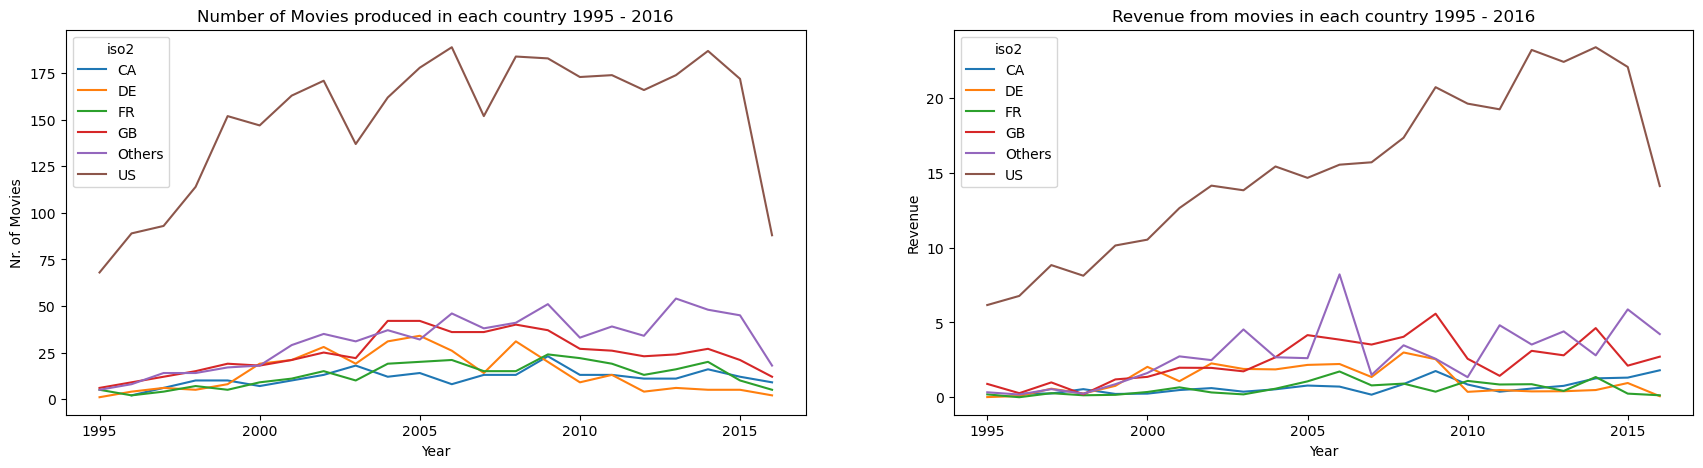

In [4]:
QUERY = '''
SELECT
    (CASE 
        when country_iso_code in ('US','GB','DE','FR','CA') then country_iso_code 
        else "Others"
    END) as iso2,
    year(release_date) as relYear, 
    COUNT(DISTINCT title) as nr_movies,
    ROUND(SUM(revenue) / 1000000000,2) as revenue 
FROM movie m
LEFT JOIN production_country pc
ON m.movie_id = pc.movie_id
LEFT JOIN country c
ON pc.country_id = c.country_id
WHERE
	country_name IS NOT NULL AND
    year(release_date) >= 1995
GROUP BY 
    (CASE 
        when country_iso_code in ('US','GB','DE','FR','CA') then country_iso_code 
        else "Others"
    END),
    year(release_date)
ORDER BY 2 DESC;
'''

cursor.execute(QUERY)

df = pd.DataFrame(list(cursor), columns=cursor.column_names)

fig, axes = plt.subplots(1,2,figsize=(21,5))

sns.lineplot(df, x='relYear', y="nr_movies", hue='iso2', ax=axes[0])
axes[0].set_title("Number of Movies produced in each country 1995 - 2016")
axes[0].set_ylabel("Nr. of Movies")
axes[0].set_xlabel("Year")

sns.lineplot(df, x='relYear', y="revenue", hue='iso2', ax=axes[1])
axes[1].set_title("Revenue from movies in each country 1995 - 2016")
axes[1].set_ylabel("Revenue")
axes[1].set_xlabel("Year")

## Linear Regression Model

A regression model is a statistichal method to test the relationship between a dependant variable and one or more independant variables.

A simple liniear regression model has the following formulas:

$$

Y_i = \beta_0 + \beta_1 \times X_i + \epsilon_i \; (1)

\quad or \quad

Y_i = \beta_0 + \beta_1 \times X_i \; (2)

$$

The errors $ \epsilon_i $ variable can often be left out of the calculus, hence we have equation (2).

## Testing Relationship between Budget and Revenue.

We've beend contracted by 2 Entertain company in order to test the relationship between their available budget for film production and the revenue output.

This being the case `revenue` is our dependant variable and `budget` is the independant variable.

### First step

A good starting point is a visualisation so to better see if there is a corelation between our variables.

<Axes: xlabel='budget', ylabel='revenue'>

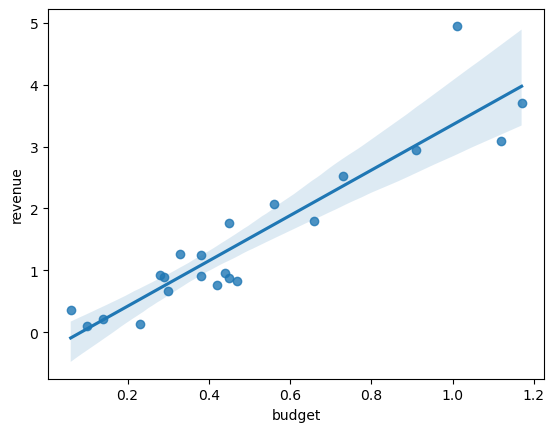

In [5]:
QUERY = '''
SELECT
	company_name,
    year(release_date) as relYear, 
    COUNT(DISTINCT title) as nr_movies,
    ROUND(SUM(budget) / 1000000000,2) as budget,
    ROUND(SUM(revenue) / 1000000000,2) as revenue
FROM movie m
LEFT JOIN production_country pc
    ON m.movie_id = pc.movie_id
LEFT JOIN country c
    ON pc.country_id = c.country_id
LEFT JOIN movie_company mc
    ON m.movie_id = mc.movie_id
LEFT JOIN production_company pcomp
    ON mc.company_id = pcomp.company_name
WHERE
	company_name IS NOT NULL AND
	country_name IS NOT NULL AND
    year(release_date) >= 1995
GROUP BY
	company_name,
    year(release_date)
ORDER BY 1, 2 DESC;
'''

cursor.execute(QUERY) # QUERY FOR DATA

df = pd.DataFrame(list(cursor), columns=cursor.column_names)

df['budget'] = df['budget'].astype('float')
df['revenue'] = df['revenue'].astype('float')

dfComp = df[df['company_name'] == '2 Entertain']

x = dfComp['budget']
y = dfComp['revenue']

sns.regplot(x=x,y=y)

As seen in the image above our data clearly follows the regression line and we can easily suppose there is indeed a correlation between the available budget to spend and the revenue output.

### Create model and fit

In [6]:
### CREATING LINEAR MODEL

x = np.array(x).reshape((-1,1))
y = np.array(y)

x = sm.add_constant(x)
res = sm.OLS(y,x).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     114.4
Date:                Sat, 13 May 2023   Prob (F-statistic):           1.01e-09
Time:                        20:03:28   Log-Likelihood:                -14.791
No. Observations:                  22   AIC:                             33.58
Df Residuals:                      20   BIC:                             35.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3141      0.200     -1.571      0.1

Based on the output above our $ R^2 = 0.85 $ which indicates a strong positive correlation based on: $ \qquad -1 < R^2 < 1 $

Also with our const (intercept) and x1 (slope) calculated now the Regression model becomes as follows:

$$

Y_i = -0.31 + 3.67 \times X_i \;

$$

### Interpretation

Based on the model above we can see that if there was no budget allocated ($ X_i = 0 $) there would be an actual revenue loss of -0.31 units. Furthermore for each unit increase of $ X_i $ the revenue is expected to raise by 3.66 units.

Supposing there would be an increase of 2 units in the budget, based on the formula $ Y_i = -0.31 + 3.67 \times 2 $ we can expect to have a estimated revenue of 7.01 units.

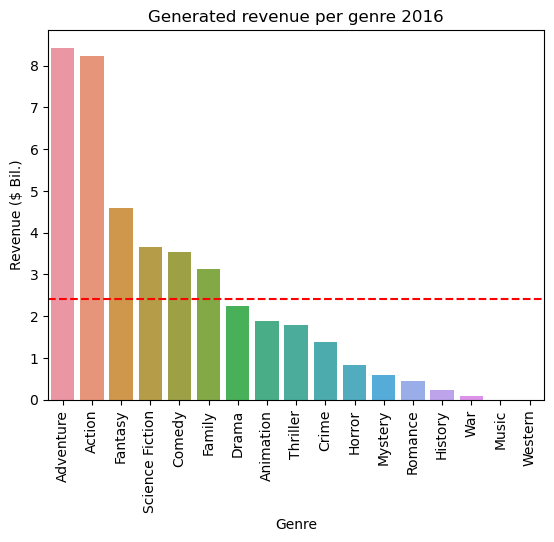

In [55]:
QUERY = '''
SELECT
    genre_name as genre,
    year(release_date) as relYear, 
    ROUND(SUM(revenue) / 1000000000,2) as revenue 
FROM movie m
LEFT JOIN movie_genres mg
ON m.movie_id = mg.movie_id
LEFT JOIN genre g
ON mg.genre_id = g.genre_id
WHERE
	genre_name IS NOT NULL AND
    year(release_date) >= 1995 AND
    year(release_date) <= 2016
GROUP BY 
    genre_name,
    year(release_date)
ORDER BY 2 DESC, 1 ASC;
'''

cursor.execute(QUERY)

df = pd.DataFrame(list(cursor), columns=cursor.column_names)
df2016 = df[df.relYear == 2016]

bar = sns.barplot(df2016,x='genre',y="revenue",order=df2016.sort_values('revenue', ascending=False).genre)
bar.set_title("Generated revenue per genre 2016")
bar.axhline(df2016.revenue.mean(),color='red',ls='dashed') ## Mean Line
bar.set_ylabel("Revenue ($ Bil.)")
bar.set_xlabel("Genre")
bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
plt.show()